# Fuzzy K-means with smoothing


Algorithm for FKM: [(Dias, 2019)](https://git.io/fuzzy-c-means)

Approach is based on:
[(Lark & Stafford, 1997)](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1744-7348.1997.tb05787.x) and 
[(Lark, 1998)](https://doi.org/10.1080/136588198242021)

In [1]:
import numpy as np
from fcmeans import FCM
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import xarray as xr
from sklearn import preprocessing as prep
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from utils import coherence, calc_NCE, smoothing
from scipy.spatial import distance_matrix

## Importing the data

In [2]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1

df_raster = stack_data.to_dataframe()[vars_vec]
rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona))

## Fuzzy k-means

Hyperparameters:
* Fuzziness exponent (set to 1.5 in [Lark (1998)](https://doi.org/10.1080/136588198242021))
* Nr. of clusters, based on NCE.
    

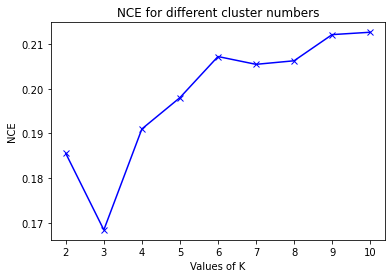

In [3]:
# Ideally should be repeated multiple times to avoid local minima of objective function

NCE = []
K = range(2,11)

for k in K:
    fcm = FCM(n_clusters = k, m=1.5, max_iter = 30000)
    fcm.fit(df_std)
    NCE.append(calc_NCE(fcm, k))

plt.plot(K, NCE, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('NCE')
plt.title('NCE for different cluster numbers')
plt.show()

In [4]:
# Optimal partition with k=3

fcm = FCM(n_clusters = 3, m=1.5, max_iter = 30000)
fcm.fit(df_std)
hard_memb = fcm.predict(df_std)
soft_memb = fcm.u

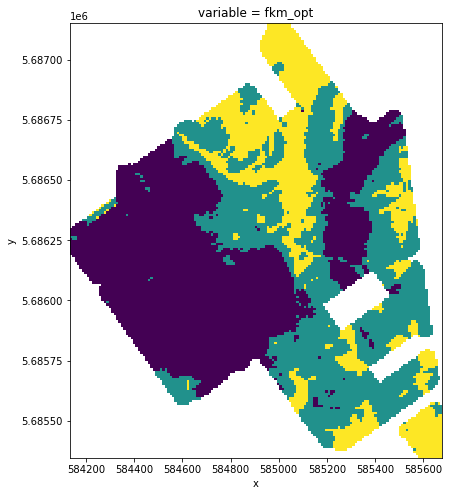

In [5]:
# The hard memberships can be used to plot the resulting classification

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = hard_memb

df_raster['fkm_opt'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='fkm_opt').plot.pcolormesh(figsize=(8,8), add_colorbar=False)
ax.axes.set_aspect('equal')

## Spatial smoothing of classification

This map is then smoothed to remove local variation in classification that is not very relevant. This is done using 
1) **The soft membership**: to know whether it is reasonable to reasign a pixel to a different class, it is more reasonable to do so if its maximum membership is small.
2) **A variogram model** of the EMI data to know how the structure of the spatial autocorrelation. It is more reasonable to reassign a pixel to the same class as its neighbors, if those neighbors are within the range for example.

Smoothing is done by adapting the soft membership values by taking a weighted average of the membership values of pixels within the neighborhood of the updated pixel, as in the following equation:


$\mu^*_{i,g} = \sum_j{w_{i,j}\mu_{j,g}}, \quad \forall\, j \, \epsilon \, R$



The weights $w_{i,j}$ are obtained from a variogram model fitted to the data.
An exponential variogram was fitted with nugget 15, sill 500 and range 1116.

The part of the variogram model relevant to determine the weights is:


$f(h_{ij})=1-exp(-\frac{h_{i,j}^2}{a^2})$, where a is the range of the variogram model.

The weights are then calculated by:


$w_{i,j} = \frac{1 - f(h_{ij})}{\sum_k{(1 - f(h_{ik})},\, \forall\, k\,\epsilon\,R}\quad \forall\, j \, \epsilon \, R$

### Calculation of weights

A range R has to be chosen, and the corresponding weights then have to be calculated. The range R can be set by the user and will determine the strength of the smoothing effect. We can compare 25m, 50m and 100m.


In [6]:
# A distance matrix is calculated from the coordinates of the raster points

coords = df_raster[~rows_with_nan].reset_index()
coords = coords.loc[:, ["x","y"]]
distance_mat = np.array(distance_matrix(coords.values, coords.values))

In [7]:
memb_upd = []
hardmemb_upd = []
for r in [25,50,100]:
    res = smoothing(soft_memb, distance_mat, 1116, r, coords)
    memb_upd.append(res[0])
    hardmemb_upd.append(res[1])

Now these weights are used to update the membership values from the fuzzy k-means classification.

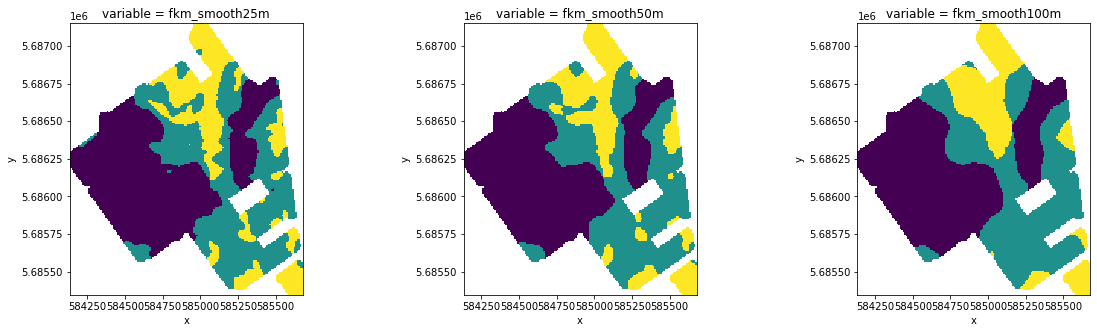

In [8]:
# The hard memberships can be used to plot the resulting classification

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = hardmemb_upd[0]
df_raster['fkm_smooth25m'] = cl

cl[~rows_with_nan] = hardmemb_upd[1]
df_raster['fkm_smooth50m'] = cl

cl[~rows_with_nan] = hardmemb_upd[2]
df_raster['fkm_smooth100m'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()

fig = plt.figure(figsize=(20,5))
i=1
for k in ['fkm_smooth25m', 'fkm_smooth50m', 'fkm_smooth100m']:
    ax = fig.add_subplot(1,3,i)
    ax = cl_array.sel(variable=k).plot.imshow(add_colorbar=False)
    ax.axes.set_aspect('equal')
    i += 1
    

Already when smoothing by taking into account points within a 25m radius, the resulting classification is much more spatially continuous and still some local variation can be observed. The smoothing increases with higher values for R.

## Validation

In [9]:
# No smoothing
coh_opt = coherence(distance_mat, 50,10, hard_memb)
DB_opt = davies_bouldin_score(df_std, hard_memb)
CH_opt = calinski_harabasz_score(df_std, hard_memb)

print("Coherence score FKM =" + str(coh_opt))
print("DB-score FKM ="+str(DB_opt))
print("CH-score FKM ="+str(CH_opt))

# For 25m
coh_opt25 = coherence(distance_mat, 50,10, hardmemb_upd[0])
DB_opt25 = davies_bouldin_score(df_std, hardmemb_upd[0])
CH_opt25 = calinski_harabasz_score(df_std, hardmemb_upd[0])

print("Coherence score (with R=25m) =" + str(coh_opt25))
print("DB-score (with R=25m) ="+str(DB_opt25))
print("CH-score (with R=25m) ="+str(CH_opt25))

# For 50m
coh_opt50 = coherence(distance_mat, 50,10, hardmemb_upd[1])
DB_opt50 = davies_bouldin_score(df_std, hardmemb_upd[1])
CH_opt50 = calinski_harabasz_score(df_std, hardmemb_upd[1])

print("Coherence score (with R=50m) =" + str(coh_opt50))
print("DB-score (with R=50m) ="+str(DB_opt50))
print("CH-score (with R=50m) ="+str(CH_opt50))



# For 100m
coh_opt100 = coherence(distance_mat, 50,10, hardmemb_upd[2])
DB_opt100 = davies_bouldin_score(df_std, hardmemb_upd[2])
CH_opt100 = calinski_harabasz_score(df_std, hardmemb_upd[2])

print("Coherence score (with R=100m) =" + str(coh_opt100))
print("DB-score (with R=100m) ="+str(DB_opt100))
print("CH-score (with R=100m) ="+str(CH_opt100))

Coherence score FKM =2.153799663755146
DB-score FKM =0.7039597861938113
CH-score FKM =32102.469996334414
Coherence score (with R=25m) =2.246267515901285
DB-score (with R=25m) =0.7299336751615932
CH-score (with R=25m) =29057.068021552015
Coherence score (with R=50m) =2.3059484212345707
DB-score (with R=50m) =0.7837019251221476
CH-score (with R=50m) =25412.07036079931
Coherence score (with R=100m) =2.395191718415576
DB-score (with R=100m) =0.9420423561938609
CH-score (with R=100m) =19663.79151652129


# References

*